In [25]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import string

In [26]:
# Load Train and Validation Data

# Load the train data
train_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv"
train_df = pd.read_csv(train_url)

# Load the validation data
val_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Val.csv"
val_df = pd.read_csv(val_url)

# Load the test data
test_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/english_test_with_labels.csv"
test_df = pd.read_csv(test_url)

In [27]:
train_df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [28]:
train_df.groupby('label').count()

,id,tweet
label,,
fake,3060,3060
real,3360,3360


In [29]:
# Upsample Fake News to Balance the Dataset
from sklearn.utils import resample

df_majority = train_df[train_df.label =='real']
df_minority = train_df[train_df.label == 'fake']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])
df_upsampled

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
5,6,"Covid Act Now found ""on average each person in...",real
...,...,...,...
3701,3702,"Trudeau airs a coronavirus update rerun, to se...",fake
2486,2487,Trumps nude statue is made in New York city be...,fake
5469,5470,Says Russia unleashed more than 500 lions on i...,fake
1982,1983,Hospital in Pakistan is overwhelmed by COVID-1...,fake


In [30]:
df_upsampled.groupby('label').count()

,id,tweet
label,,
fake,3360,3360
real,3360,3360


In [31]:
## Validating that dataset is balanced after upsampling
print("Real News Dataset Size: " + str(df_majority.shape))
print("Fake News Dataset Size Before Upsampling: " + str(df_minority.shape))
print("Fake News Dataset Size After Upsampling: " + str(negative_upsample.shape))

Real News Dataset Size: (3360, 3)
Fake News Dataset Size Before Upsampling: (3060, 3)
Fake News Dataset Size After Upsampling: (3360, 3)


In [32]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB


In [33]:
## Split train and test, drop id column, and binarize target
x_train = df_upsampled
x_val = val_df
x_test = test_df
y_train = df_upsampled[['label']].to_numpy()
y_val = val_df[['label']].to_numpy()
y_test = test_df[['label']].to_numpy()
from sklearn import preprocessing
y_train= preprocessing.label_binarize(y_train, classes =['real', 'fake'])
y_val = preprocessing.label_binarize(y_val, classes=['real', 'fake'])
y_test = preprocessing.label_binarize(y_test, classes=['real', 'fake'])

In [34]:
#Preprocessing 

In [35]:
# Download stopwords and its dependencies for preprocessing
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wn = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
pip install cleantext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from string import punctuation

def lemmatize_preprocessed_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Lemmatize words
    lemmatized_words = [wn.lemmatize(word) for word in words]
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in lemmatized_words)
    
    return cleaned_news_excerpt

In [38]:
# Pre-Processed News Dataset 2
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation
# 5. stem words

def stemmed_preprocessed_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Stem words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in stemmed_words)
    
    return cleaned_news_excerpt

In [39]:
# Pre-Processed News Dataset 3
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation

def preprocess_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in words)
    
    return cleaned_news_excerpt

In [40]:
import nltk
nltk.download('omw-1.4')
x_train["lemmatized_tweet"] = x_train["tweet"].apply(lemmatize_preprocessed_news)
x_train["stemmed_tweet"] = x_train["tweet"].apply(stemmed_preprocessed_news)
x_train["cleaned_tweet"] = x_train["tweet"].apply(preprocess_news)
x_train["lemmatized_tokens"] = x_train["lemmatized_tweet"].str.split(" ")
x_train["stemmed_tokens"] = x_train["stemmed_tweet"].str.split(" ")
x_val["lemmatized_tweet"] = x_val["tweet"].apply(lemmatize_preprocessed_news)
x_val["stemmed_tweet"] = x_val["tweet"].apply(stemmed_preprocessed_news)
x_val["lemmatized_tokens"] = x_val["lemmatized_tweet"].str.split(" ")
x_val["stemmed_tokens"] = x_val["stemmed_tweet"].str.split(" ")
x_test["lemmatized_tweet"] = x_val["tweet"].apply(lemmatize_preprocessed_news)
x_test["stemmed_tweet"] = x_val["tweet"].apply(stemmed_preprocessed_news)
x_test["lemmatized_tokens"] = x_test["lemmatized_tweet"].str.split(" ")
x_test["stemmed_tokens"] = x_test["stemmed_tweet"].str.split(" ")
x_train.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,id,tweet,label,lemmatized_tweet,stemmed_tweet,cleaned_tweet,lemmatized_tokens,stemmed_tokens
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently report 99031 death general discr...,cdc current report 99031 death gener discrep d...,cdc currently reports 99031 deaths general dis...,"[cdc, currently, report, 99031, death, general...","[cdc, current, report, 99031, death, gener, di..."
1,2,States reported 1121 deaths a small rise from ...,real,state reported 1121 death small rise last tues...,state report 1121 death small rise last tuesda...,states reported 1121 deaths small rise last tu...,"[state, reported, 1121, death, small, rise, la...","[state, report, 1121, death, small, rise, last..."
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona 1524 covid testing laborator...,indiafightscorona 1524 covid test laboratori i...,indiafightscorona 1524 covid testing laborator...,"[indiafightscorona, 1524, covid, testing, labo...","[indiafightscorona, 1524, covid, test, laborat..."
4,5,Populous states can generate large case counts...,real,populous state generate large case count look ...,popul state gener larg case count look new cas...,populous states generate large case counts loo...,"[populous, state, generate, large, case, count...","[popul, state, gener, larg, case, count, look,..."
5,6,"Covid Act Now found ""on average each person in...",real,covid act found on average person illinois cov...,covid act found on averag person illinoi covid...,covid act found on average person illinois cov...,"[covid, act, found, on, average, person, illin...","[covid, act, found, on, averag, person, illino..."


In [41]:
## Create Bag of Words preprocessed datasets
from sklearn.feature_extraction.text import CountVectorizer

corpus1 = x_train['tweet'].values.tolist()
corpus2 = x_train['tweet'].values.tolist()
corpus1_val = x_val['tweet'].values.tolist()
corpus2_val = x_val['tweet'].values.tolist()
corpus1_test = x_test['tweet'].values.tolist()
corpus2_test = x_test['tweet'].values.tolist()

# Lemmatized One-hot Encoding
vectorizer = CountVectorizer(binary = True, preprocessor= lemmatize_preprocessed_news)
x_lemmatized_ohe = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_ohe_val = vectorizer.transform(corpus1_val).toarray()
x_lemmatized_ohe_test = vectorizer.transform(corpus1_test).toarray()

# Stemmed One-hot Encoding
x_stemmed_ohe = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_ohe_val = vectorizer.transform(corpus2_val).toarray()
x_stemmed_ohe_test = vectorizer.transform(corpus2_test).toarray()

# Lemmatized Bag of Words
vectorizer = CountVectorizer(preprocessor= lemmatize_preprocessed_news)
x_lemmatized_bow = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_bow_val = vectorizer.transform(corpus1_val).toarray()
x_lemmatized_bow_test = vectorizer.transform(corpus1_test).toarray()

# Stemmed Bag of Words
vectorizer = CountVectorizer(preprocessor=stemmed_preprocessed_news)
x_stemmed_bow = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_bow_val = vectorizer.transform(corpus2_val).toarray()
x_stemmed_bow_test = vectorizer.transform(corpus2_test).toarray()


In [42]:
## Create TFIDF preprocessed datasets
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor = lemmatize_preprocessed_news)
x_lemmatized_tfidf = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_tfidf_val = vectorizer.transform(corpus1_val).toarray()
x_lemmatized_tfidf_test = vectorizer.transform(corpus1_test).toarray()
vectorizer = TfidfVectorizer(preprocessor=stemmed_preprocessed_news)
x_stemmed_tfidf = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_tfidf_val = vectorizer.transform(corpus2_val).toarray()
x_stemmed_tfidf_test = vectorizer.transform(corpus2_test).toarray()

In [43]:
pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
def create_w2vec_vectors(model, train, test, val):
  words = set(model.wv.index_to_key)
  x_train = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in train])
  x_val = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in val])
  x_test = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in test])

  x_train_avg = []
  for i in x_train:
    if i.size:
      x_train_avg.append(i.mean(axis=0))
    else:
        x_train_avg.append(np.zeros(100, dtype=float))

  x_val_avg = []
  for i in x_val:
    if i.size:
      x_val_avg.append(i.mean(axis=0))
    else:
        x_val_avg.append(np.zeros(100, dtype=float))

  x_test_avg = []
  for i in x_test:
    if i.size:
        x_test_avg.append(i.mean(axis=0))
    else:
        x_test_avg.append(np.zeros(100, dtype=float))
  return x_train_avg, x_val_avg, x_test_avg


In [45]:
## Create Word2Vec vectors
import itertools
import gensim
from gensim.models import Word2Vec
lemmatized_tokns = list(x_train['lemmatized_tokens'])
lemmatized_token_list = list(itertools.chain(*lemmatized_tokns))

CBOW = gensim.models.Word2Vec([lemmatized_token_list], window =5, min_count=1, workers = 4)
SG = gensim.models.Word2Vec([lemmatized_token_list], window =5, min_count=1, workers = 4, sg=1)

#x_train['lemmatized_tokens'].values

#lemmatized_train_CBOW, lemmatized_val_CBOW, lemmatized_test_CBOW = 
lemmatized_train_CBOW, lemmatized_val_CBOW, lemmatized_test_CBOW = create_w2vec_vectors(CBOW, x_train['lemmatized_tokens'].values, x_val['lemmatized_tokens'].values, x_test['lemmatized_tokens'].values)

lemmatized_train_SG, lemmatized_val_SG, lemmatized_test_SG = create_w2vec_vectors(SG, x_train["lemmatized_tokens"].values, x_val["lemmatized_tokens"].values, x_test["lemmatized_tokens"].values)



stemmed_tokens = list(x_train['stemmed_tokens'])
stemmed_token_list = list(itertools.chain(*stemmed_tokens))
CBOW = gensim.models.Word2Vec([stemmed_token_list], window =5, min_count=1, workers = 4)
SG = gensim.models.Word2Vec([stemmed_token_list], window =5, min_count=1, workers = 4, sg=1)

stemmed_train_CBOW, stemmed_val_CBOW, stemmed_test_CBOW = create_w2vec_vectors(CBOW, x_train["stemmed_tokens"].values, x_val["stemmed_tokens"].values, x_test["stemmed_tokens"].values)

stemmed_train_SG, stemmed_val_SG, stemmed_test_SG = create_w2vec_vectors(SG, x_train["stemmed_tokens"].values, x_val["stemmed_tokens"].values, x_test["stemmed_tokens"].values)

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
def plot_confusion_matrix(y_true, y_pred):
  cf_matrix = confusion_matrix(y_true, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  return

In [47]:
#plot precision recall score
from sklearn.metrics import precision_recall_curve
def plot_precision_recall(y_test, y_score):
  precision, recall, thresholds = precision_recall_curve(y_test, y_score)
  fig, ax = plt.subplots()
  ax.plot(recall, precision, color='purple')
  ax.set_title('Precision-Recall Curve')
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  plt.show()

Tuning Naive Bayes Model

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
def tune_nvb(x_train,y_train):
  param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)}
  nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
  nbModel_grid.fit(x_stemmed_bow, y_train.ravel())
  return nbModel_grid.best_params_

In [ ]:
tune_nvb(x_lemmatized_bow,y_train)

In [39]:
#@title Building Naive Bayes Model


In [40]:
# Function for running Multinomial Naive Bayes and obtaining evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
def build_nf(x_train, y_train, x_val, y_val):
  clf = GaussianNB(priors=None, var_smoothing=0.0012328467394420659)
  clf.fit(x_train, y_train.ravel())
  y_pred = clf.predict(x_val)
  print(classification_report(y_pred,y_val))
  plot_confusion_matrix(y_val, y_pred)
  RocCurveDisplay.from_estimator(clf, x_val, y_val)
  y_score = clf.predict_proba(x_val)[:, 1]
  plot_precision_recall(y_val, y_score)
  #print(best_params)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1057
           1       0.95      0.89      0.92      1083

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



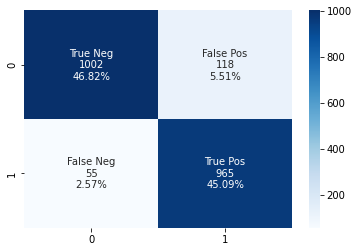

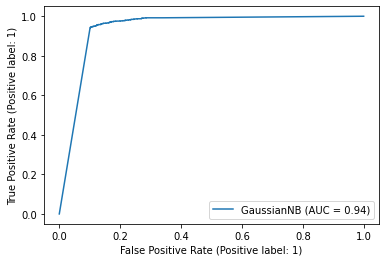

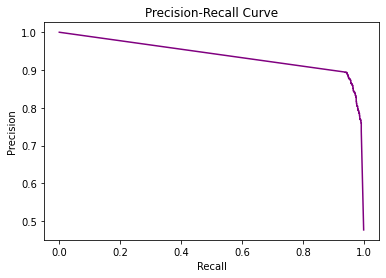

In [41]:
build_nf(x_lemmatized_bow,y_train,x_lemmatized_bow_test,y_test)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1160
           1       0.86      0.89      0.87       980

    accuracy                           0.88      2140
   macro avg       0.88      0.88      0.88      2140
weighted avg       0.88      0.88      0.88      2140



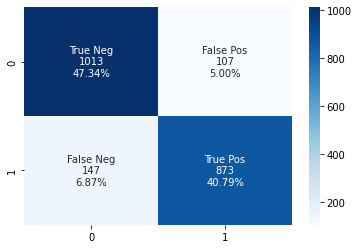

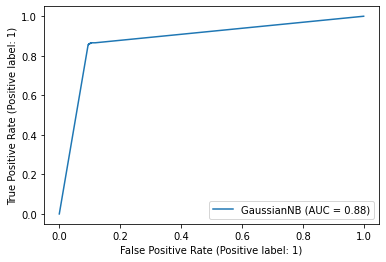

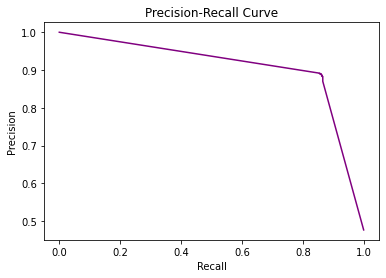

In [42]:
build_nf(x_lemmatized_tfidf,y_train,x_lemmatized_tfidf_test,y_test)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1078
           1       0.92      0.88      0.90      1062

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.90      0.90      0.90      2140



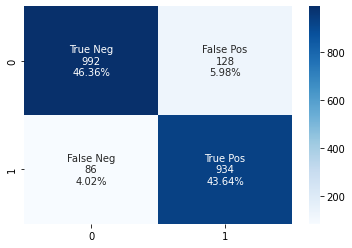

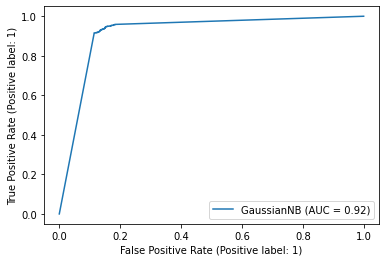

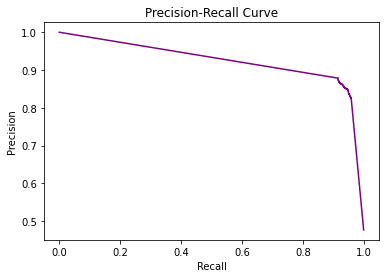

In [43]:
build_nf(x_lemmatized_ohe,y_train,x_lemmatized_ohe_test,y_test)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1048
           1       0.95      0.89      0.92      1092

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



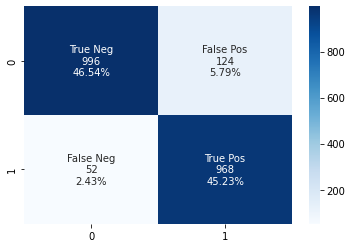

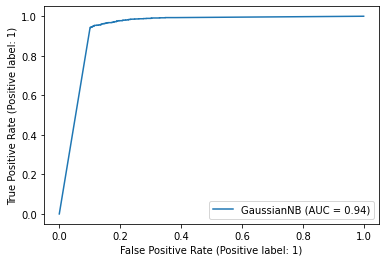

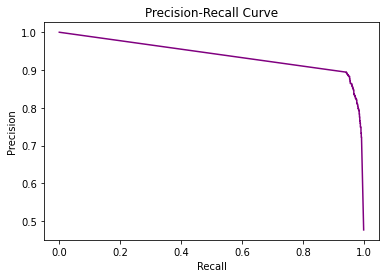

In [44]:
build_nf(x_stemmed_bow,y_train,x_stemmed_bow_test,y_test)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1118
           1       0.87      0.86      0.86      1022

    accuracy                           0.87      2140
   macro avg       0.87      0.87      0.87      2140
weighted avg       0.87      0.87      0.87      2140



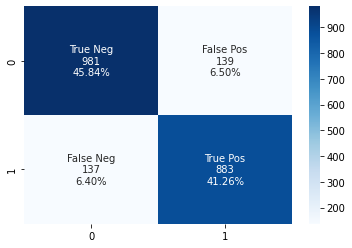

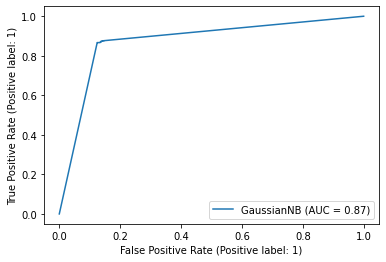

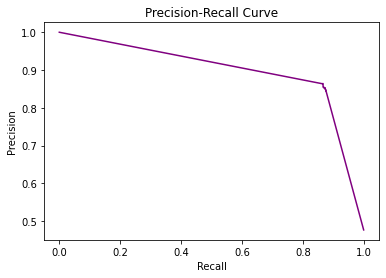

In [45]:
build_nf(x_stemmed_tfidf,y_train,x_stemmed_tfidf_test,y_test)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1078
           1       0.92      0.88      0.90      1062

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.90      0.90      0.90      2140



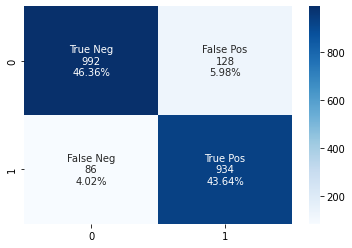

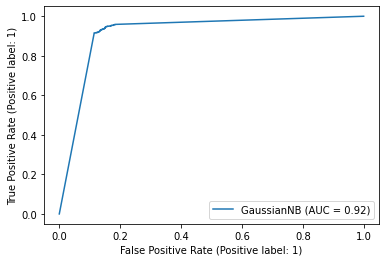

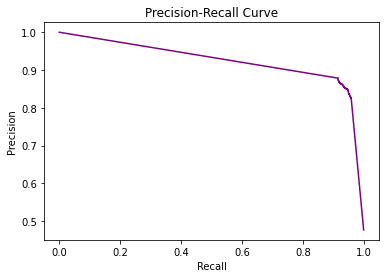

In [47]:
build_nf(x_stemmed_ohe,y_train,x_stemmed_ohe_test,y_test)

              precision    recall  f1-score   support

           0       0.48      0.51      0.49      1060
           1       0.49      0.46      0.47      1080

    accuracy                           0.48      2140
   macro avg       0.48      0.48      0.48      2140
weighted avg       0.48      0.48      0.48      2140



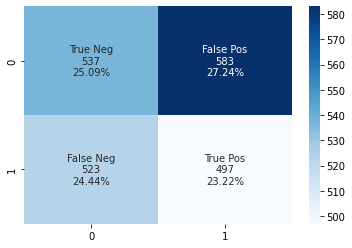

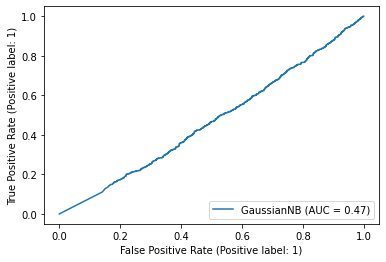

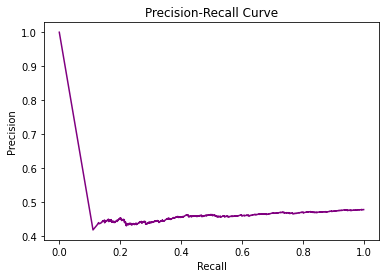

In [48]:
build_nf(lemmatized_train_CBOW,y_train,lemmatized_test_CBOW,y_test)

              precision    recall  f1-score   support

           0       0.47      0.51      0.49      1027
           1       0.50      0.46      0.48      1113

    accuracy                           0.48      2140
   macro avg       0.48      0.48      0.48      2140
weighted avg       0.49      0.48      0.48      2140



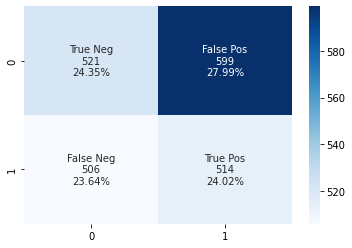

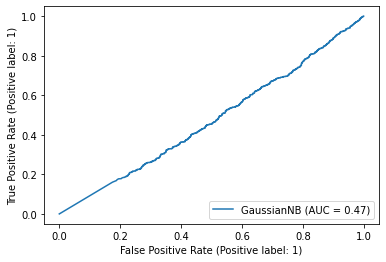

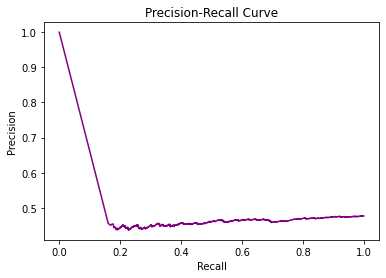

In [49]:
build_nf(stemmed_train_CBOW,y_train,stemmed_test_CBOW,y_test)

              precision    recall  f1-score   support

           0       0.44      0.50      0.47       976
           1       0.52      0.46      0.49      1164

    accuracy                           0.48      2140
   macro avg       0.48      0.48      0.48      2140
weighted avg       0.48      0.48      0.48      2140



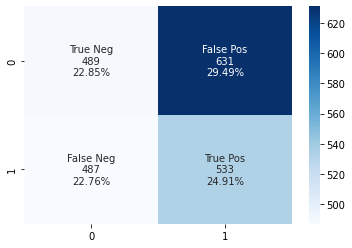

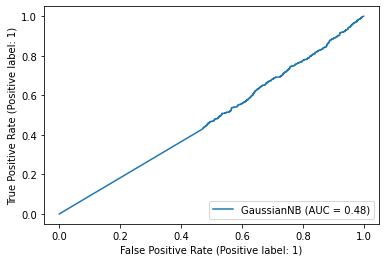

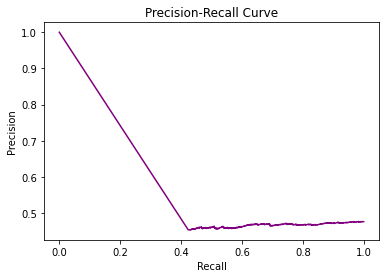

In [50]:
build_nf(lemmatized_train_SG,y_train,lemmatized_test_SG,y_test)

              precision    recall  f1-score   support

           0       0.46      0.51      0.48      1016
           1       0.51      0.46      0.48      1124

    accuracy                           0.48      2140
   macro avg       0.48      0.48      0.48      2140
weighted avg       0.49      0.48      0.48      2140



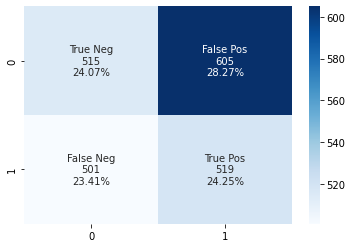

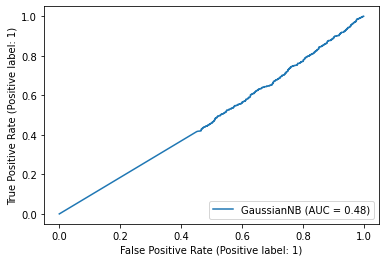

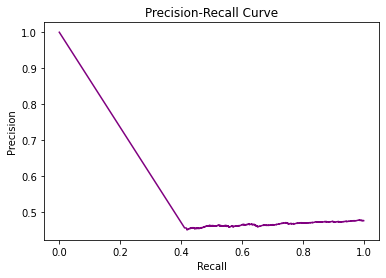

In [51]:
build_nf(stemmed_train_SG,y_train,stemmed_test_SG,y_test)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
def tune_lgression(x_train,y_train):
    x_train, y_train = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# define models and parameters
    model = LogisticRegression()
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = np.logspace(-4, 4, 50)
# define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(x_train, y_train) 
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_params_

In [ ]:
tune_lgression(x_stemmed_bow,y_train)

Best: 0.961667 using {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
0.960667 (0.016918) with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.960667 (0.016918) with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.961667 (0.017337) with: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
0.960000 (0.018619) with: {'C': 0.00014563484775012445, 'penalty': 'l2', 'solver': 'newton-cg'}
0.960000 (0.018619) with: {'C': 0.00014563484775012445, 'penalty': 'l2', 'solver': 'lbfgs'}
0.959667 (0.017604) with: {'C': 0.00014563484775012445, 'penalty': 'l2', 'solver': 'liblinear'}
0.958000 (0.019218) with: {'C': 0.00021209508879201905, 'penalty': 'l2', 'solver': 'newton-cg'}
0.958000 (0.019218) with: {'C': 0.00021209508879201905, 'penalty': 'l2', 'solver': 'lbfgs'}
0.957667 (0.019779) with: {'C': 0.00021209508879201905, 'penalty': 'l2', 'solver': 'liblinear'}
0.955333 (0.019276) with: {'C': 0.00030888435964774815, 'penalty': 'l2', 'solver': 'newton-cg'}
0.955333 (0.019276) with:

{'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}

In [72]:
# Function for running tuned Logistic Regression and obtaining evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
def build_lgregression(x_train, y_train, x_val, y_val):
  clf = LogisticRegression(C= 0.0001, penalty= 'l2', solver= 'liblinear')
  clf.fit(x_train, y_train.ravel())
  y_pred = clf.predict(x_val)
  print(classification_report(y_pred,y_val))
  plot_confusion_matrix(y_val, y_pred)
  RocCurveDisplay.from_estimator(clf, x_val, y_val)
  y_score = clf.predict_proba(x_val)[:, 1]
  plot_precision_recall(y_val, y_score)
  #print(best_params)

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1383
           1       0.62      0.84      0.72       757

    accuracy                           0.76      2140
   macro avg       0.76      0.78      0.76      2140
weighted avg       0.80      0.76      0.77      2140



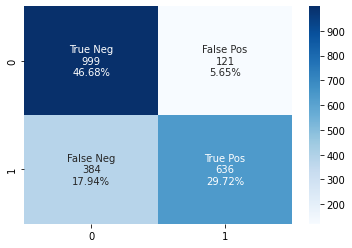

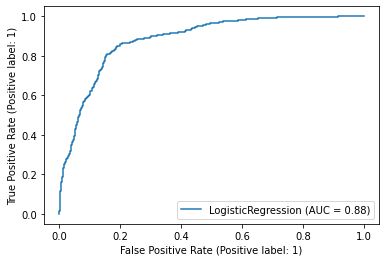

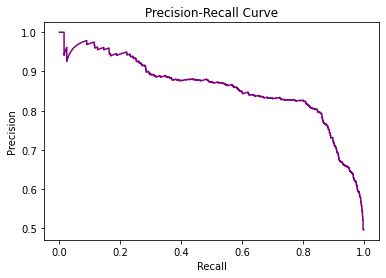

In [73]:
build_lgregression(x_stemmed_bow,y_train,x_stemmed_bow_test,y_test)

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1276
           1       0.75      0.89      0.82       864

    accuracy                           0.84      2140
   macro avg       0.83      0.85      0.84      2140
weighted avg       0.85      0.84      0.84      2140



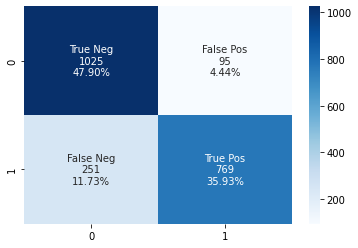

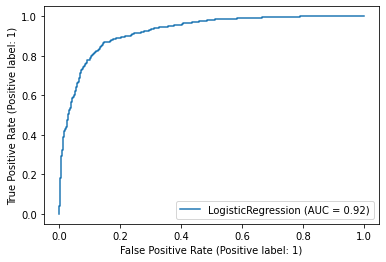

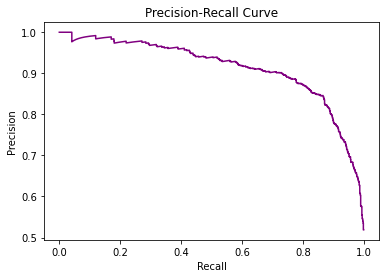

In [74]:
build_lgregression(x_stemmed_tfidf,y_train,x_stemmed_tfidf_test,y_test)

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1373
           1       0.64      0.84      0.73       767

    accuracy                           0.77      2140
   macro avg       0.76      0.79      0.76      2140
weighted avg       0.80      0.77      0.78      2140



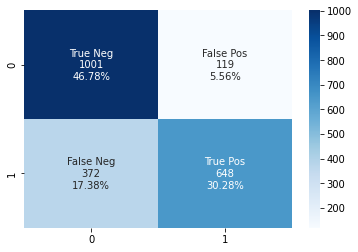

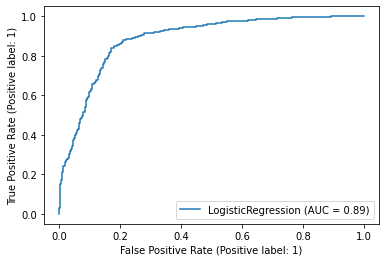

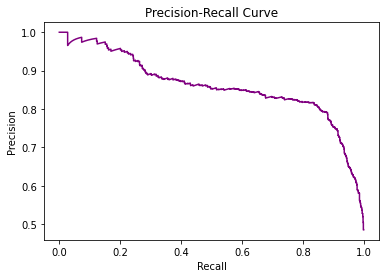

In [75]:
build_lgregression(x_stemmed_ohe,y_train,x_stemmed_ohe_test,y_test)

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1379
           1       0.62      0.84      0.72       761

    accuracy                           0.76      2140
   macro avg       0.76      0.78      0.76      2140
weighted avg       0.80      0.76      0.77      2140



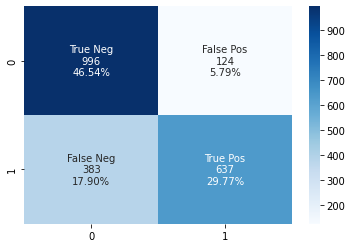

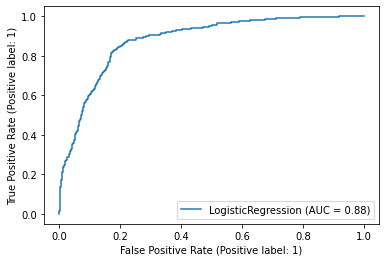

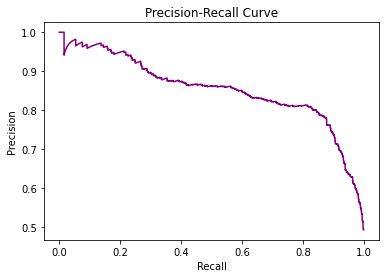

In [77]:
build_lgregression(x_lemmatized_bow,y_train,x_lemmatized_bow_test,y_test)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1247
           1       0.78      0.89      0.83       893

    accuracy                           0.85      2140
   macro avg       0.84      0.85      0.84      2140
weighted avg       0.85      0.85      0.85      2140



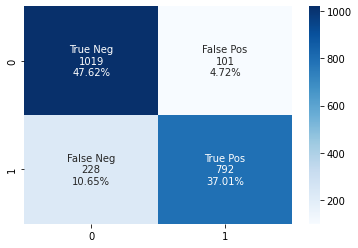

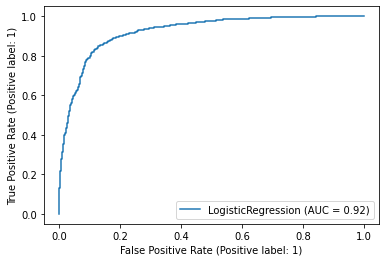

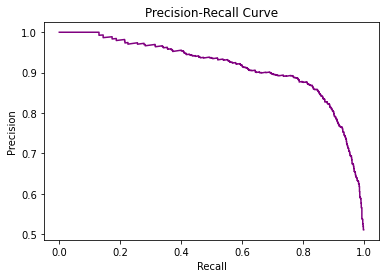

In [78]:
build_lgregression(x_lemmatized_tfidf,y_train,x_lemmatized_tfidf_test,y_test)

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1373
           1       0.64      0.84      0.73       767

    accuracy                           0.77      2140
   macro avg       0.76      0.79      0.76      2140
weighted avg       0.80      0.77      0.78      2140



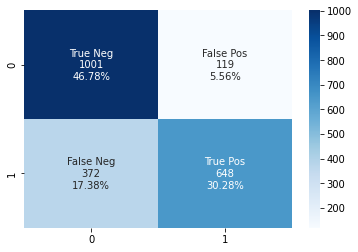

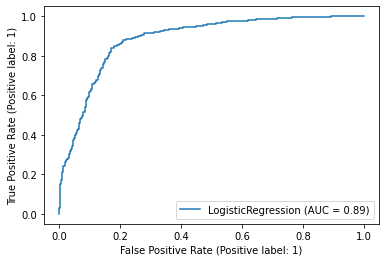

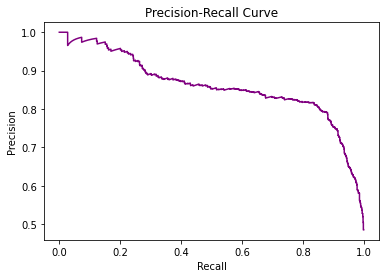

In [79]:
build_lgregression(x_lemmatized_ohe,y_train,x_lemmatized_ohe_test,y_test)

              precision    recall  f1-score   support

           0       0.98      0.53      0.69      2068
           1       0.04      0.62      0.08        72

    accuracy                           0.53      2140
   macro avg       0.51      0.58      0.38      2140
weighted avg       0.94      0.53      0.67      2140



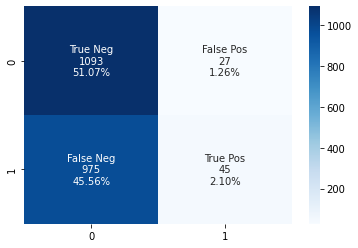

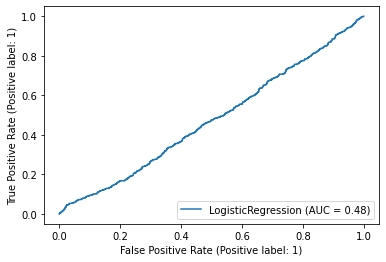

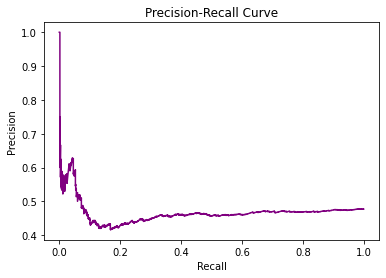

In [80]:
build_lgregression(lemmatized_train_CBOW,y_train,lemmatized_test_CBOW,y_test)

              precision    recall  f1-score   support

           0       0.99      0.52      0.69      2125
           1       0.01      0.47      0.01        15

    accuracy                           0.52      2140
   macro avg       0.50      0.49      0.35      2140
weighted avg       0.99      0.52      0.68      2140



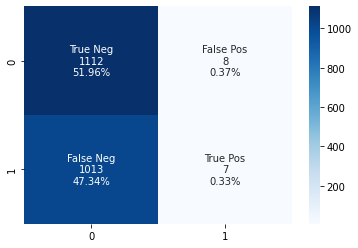

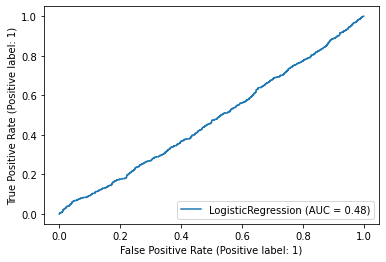

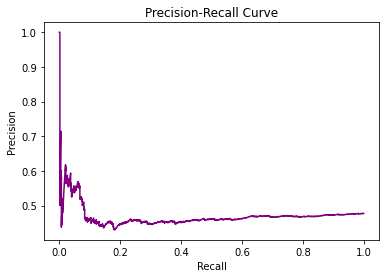

In [81]:
build_lgregression(lemmatized_train_SG,y_train,lemmatized_test_SG,y_test)

              precision    recall  f1-score   support

           0       0.98      0.52      0.68      2100
           1       0.02      0.50      0.04        40

    accuracy                           0.52      2140
   macro avg       0.50      0.51      0.36      2140
weighted avg       0.96      0.52      0.67      2140



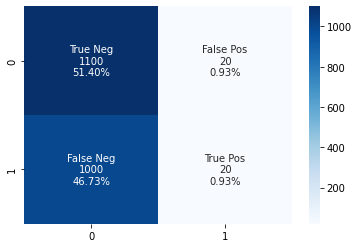

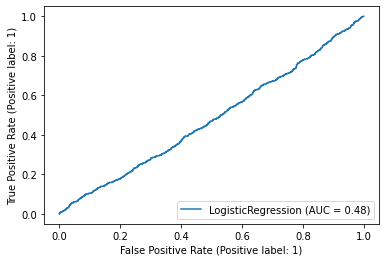

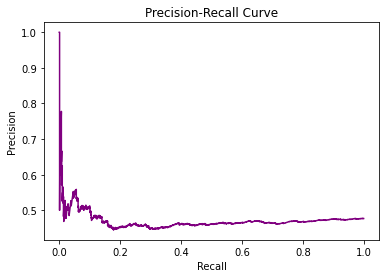

In [82]:
build_lgregression(stemmed_train_CBOW,y_train,stemmed_test_CBOW,y_test)

              precision    recall  f1-score   support

           0       1.00      0.52      0.69      2127
           1       0.01      0.62      0.02        13

    accuracy                           0.52      2140
   macro avg       0.50      0.57      0.35      2140
weighted avg       0.99      0.52      0.68      2140



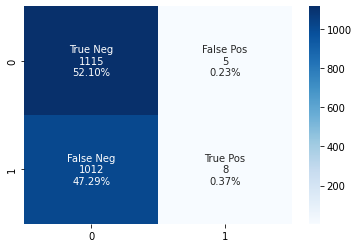

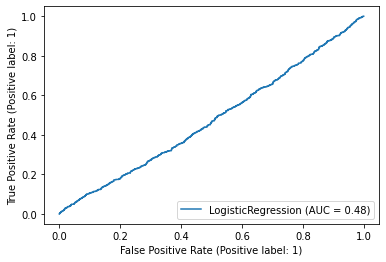

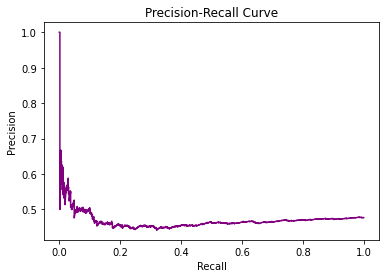

In [83]:
build_lgregression(stemmed_train_SG,y_train,stemmed_test_SG,y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','poly','sigmoid']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(x_stemmed_bow, y_train)
print(grid.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [50]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
def tune_svc(x_train,y_train):
  param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
  grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  grid.fit(x_train, y_train)
  return grid.best_params_

In [ ]:
tune_svc(x_stemmed_bow,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [25]:
# Function for running SVM  and obtaining evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.svm import SVC

def build_svc(x_train, y_train, x_val, y_val):
  clf = SVC(C=10, kernel='rbf', gamma=0.01,probability=True)
  clf.fit(x_train, y_train.ravel())
  y_pred = clf.predict(x_val)
  print(classification_report(y_pred,y_val))
  plot_confusion_matrix(y_val, y_pred)
  RocCurveDisplay.from_estimator(clf, x_val, y_val)
  y_score = clf.predict_proba(x_val)[:, 1]
  plot_precision_recall(y_val, y_score)
  #print(best_params)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1130
           1       0.91      0.92      0.91      1010

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



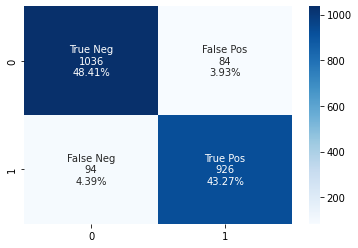

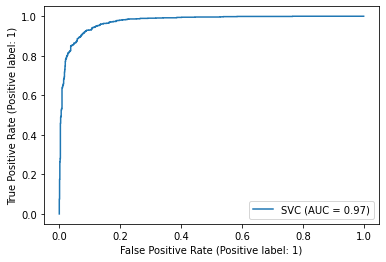

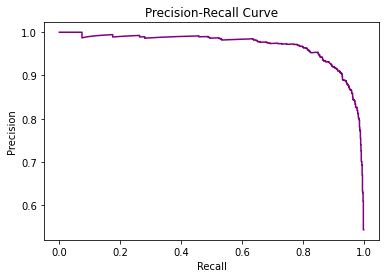

In [38]:
build_svc(x_stemmed_bow,y_train,x_stemmed_bow_val,y_val)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1069
           1       0.94      0.89      0.91      1071

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



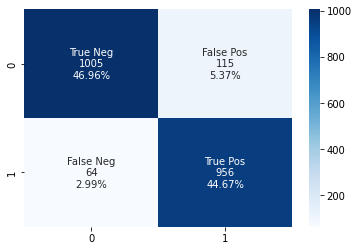

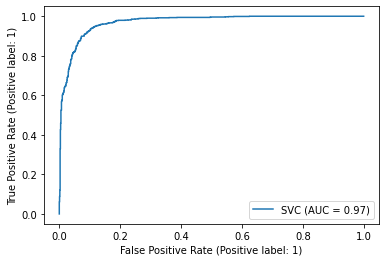

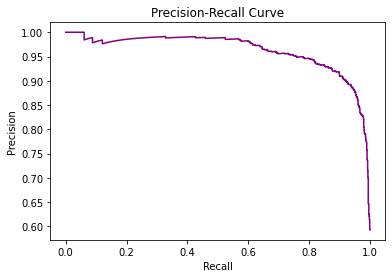

In [52]:
build_svc(x_stemmed_tfidf,y_train,x_stemmed_tfidf_test,y_test)


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1123
           1       0.91      0.91      0.91      1017

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



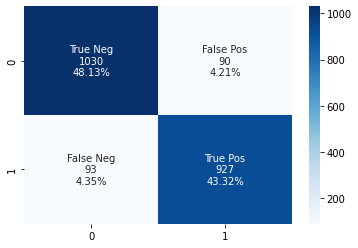

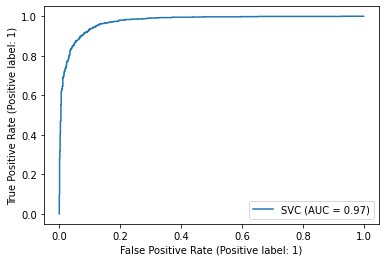

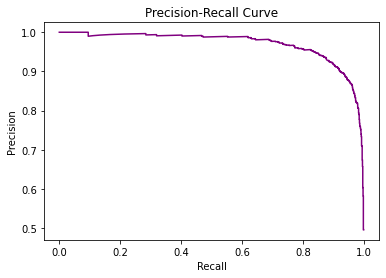

In [54]:
build_svc(x_stemmed_ohe,y_train,x_stemmed_ohe_test,y_test)


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1131
           1       0.91      0.92      0.91      1009

    accuracy                           0.92      2140
   macro avg       0.91      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



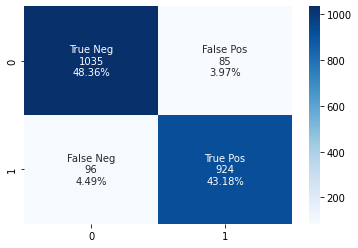

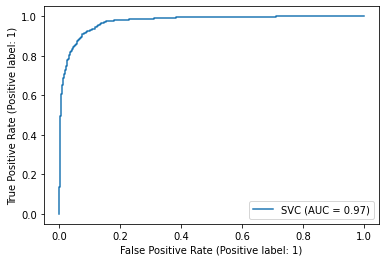

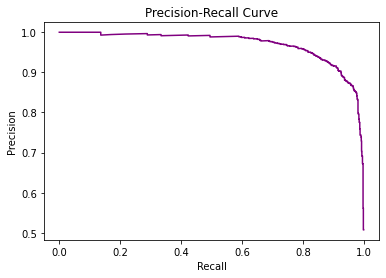

In [26]:
build_svc(x_lemmatized_bow,y_train,x_lemmatized_bow_test,y_test)


              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1074
           1       0.94      0.89      0.91      1066

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



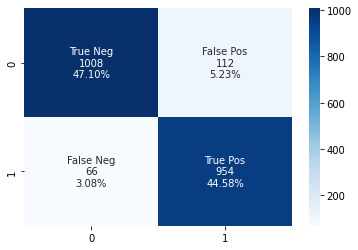

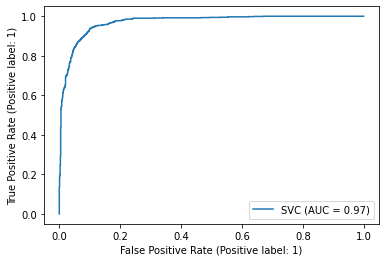

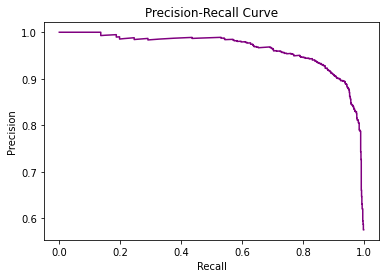

In [53]:
build_svc(x_lemmatized_tfidf,y_train,x_lemmatized_tfidf_test,y_test)


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1123
           1       0.91      0.91      0.91      1017

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



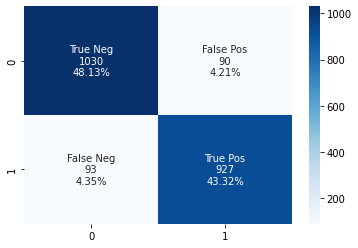

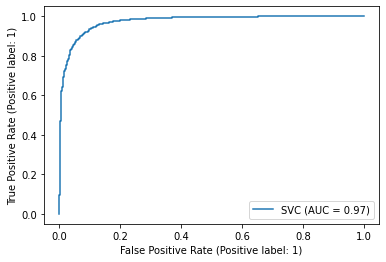

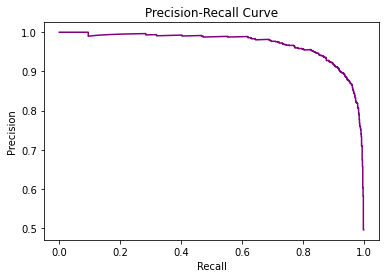

In [27]:
build_svc(x_lemmatized_ohe,y_train,x_lemmatized_ohe_test,y_test)


              precision    recall  f1-score   support

           0       0.00      0.57      0.01         7
           1       1.00      0.48      0.65      2133

    accuracy                           0.48      2140
   macro avg       0.50      0.52      0.33      2140
weighted avg       0.99      0.48      0.64      2140



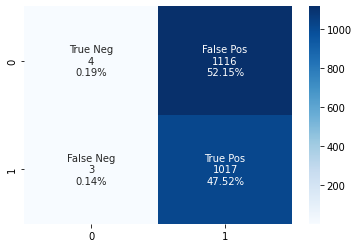

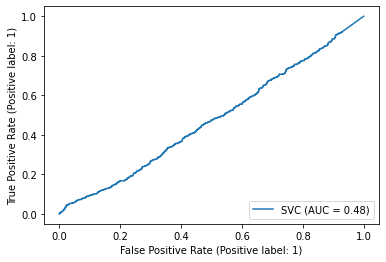

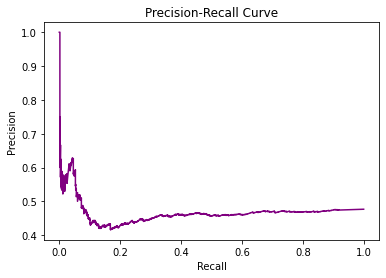

In [28]:
build_svc(lemmatized_train_CBOW,y_train,lemmatized_test_CBOW,y_test)


              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1089
           1       0.47      0.46      0.47      1051

    accuracy                           0.48      2140
   macro avg       0.48      0.48      0.48      2140
weighted avg       0.48      0.48      0.48      2140



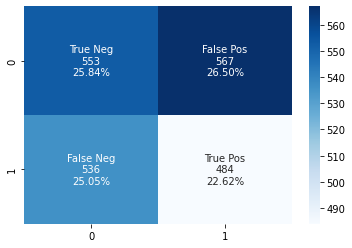

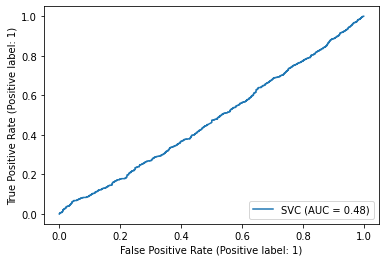

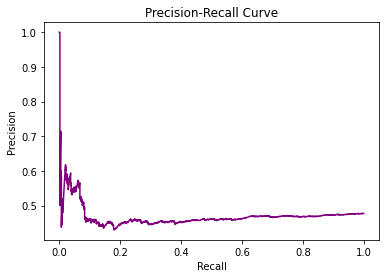

In [29]:
build_svc(lemmatized_train_SG,y_train,lemmatized_test_SG,y_test)


              precision    recall  f1-score   support

           0       0.00      0.71      0.01         7
           1       1.00      0.48      0.65      2133

    accuracy                           0.48      2140
   macro avg       0.50      0.60      0.33      2140
weighted avg       0.99      0.48      0.64      2140



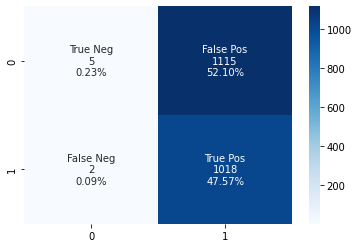

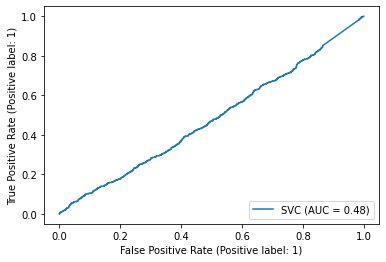

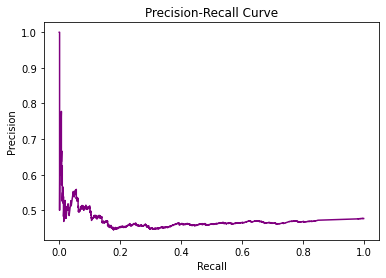

In [30]:
build_svc(stemmed_train_CBOW,y_train,stemmed_test_CBOW,y_test)


              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1118
           1       0.46      0.46      0.46      1022

    accuracy                           0.48      2140
   macro avg       0.48      0.48      0.48      2140
weighted avg       0.48      0.48      0.48      2140



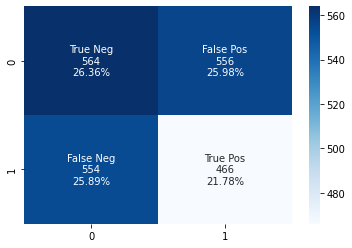

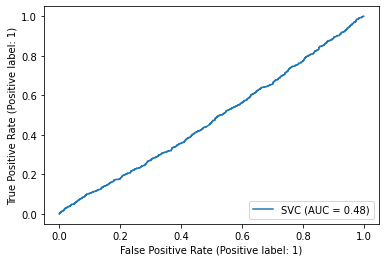

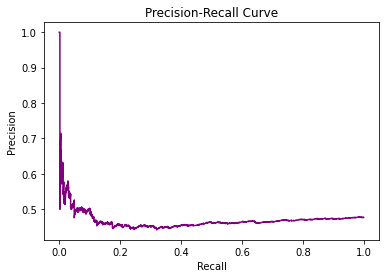

In [31]:
build_svc(stemmed_train_SG,y_train,stemmed_test_SG,y_test)
